# 1. Setting up the enviroment

In [ ]:
# Install necessary python dependencies
! pip install -r requirements.txt

In [4]:
# Define key variables
# Add the into-the-multiverse folder to the Python path. This allows the helperfunction
# to be used

#import sys
#sys.path.insert(1, 'into-the-multiverse')

# To run LOCALLY
import os
os.chdir('/Users/jessica/Code/into-the-multiverse-revised')
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(1234)

In [6]:
from pathlib import Path
# Define paths - REMOTE
#PROJECT_ROOT = Path.cwd()
#data_path = PROJECT_ROOT / 'into-the-multiverse' /'data' / 'abide'
#output_path = PROJECT_ROOT / 'into-the-multiverse' / 'output'/ 'abide'

# Define paths - LOCALLY
# All paths are expected to be Path objects
PROJECT_ROOT = Path.cwd()
data_root = PROJECT_ROOT / 'data' / 'abide'
output_path = PROJECT_ROOT / 'output' / 'abide'
# Change accordingly to where the raw data provided by
# (http://preprocessed-connectomes-project.org/abide/download.html) is downloaded
data_raw = Path('/Volumes/abide')
if not output_path.is_dir():
    output_path.mkdir(parents=True)

In [7]:
# Define the space variables
derivatives = ['rois_tt', 'rois_ho', 'rois_ez', 'rois_dosenbach160', 'rois_cc400', 'rois_cc200']
pipelines = ['cpac', 'ccs', 'dparsf', 'niak']
strategies = ['filt_global', 'nofilt_global', 'nofilt_noglobal', 'filt_noglobal']
conn_metrics = ['tangent', 'correlation', 'partial correlation', 'covariance']

# 2. Run the different analysis to bild the space

The next step assumes that the data has been downloaded. The data can be downloaded from (http://preprocessed-connectomes-project.org/abide/download.html). For time reasons, we will not download the data within this notebook. To run this script the code expects the files to be in the following structure:

```
├── ccs
│   ├── filt_global
│   ├── filt_noglobal
│   ├── nofilt_global
│   └── nofilt_noglobal
├── cpac
│   ├── filt_global
│   ├── filt_noglobal
│   ├── nofilt_global
│   └── nofilt_noglobal
├── dparsf
│   ├── filt_global
│   ├── filt_noglobal
│   ├── nofilt_global
│   └── nofilt_noglobal
└── niak
    ├── filt_global
    ├── filt_noglobal
    ├── nofilt_global
    └── nofilt_noglobal
```

However, to facilitate reproducibility together with this code. We are providing the file `output/abide/abide_space.pckl`, which contains the output from the next cell. 

In [ ]:
# select the subjects we want to use to create the space (about 20% of the total subjects) making sure that
# both classes are equally represented

# Load data demographics
abide_df = load_abide_demographics(data_root)
indices = np.arange(len(abide_df))
idx_space, idx_train = train_test_split(indices, test_size=.8, train_size=.2, random_state=0,
                                        shuffle=True, stratify=abide_df['DX_GROUP'])
# Visualise stratification
train_df = abide_df.iloc[idx_train]
print('Numbers on training df')
print(train_df['DX_GROUP'].value_counts())
space_df = abide_df.iloc[idx_space]
print('Numbers on space df')
print(space_df['DX_GROUP'].value_counts())

# save list of indexes of the data split
indices = {'idx_train': idx_train.tolist(),
           'idx_space': idx_space.tolist()}
with open((output_path / f'indices_space_train.json'), 'w') as handle:
    json.dump(indices, handle)

In [ ]:
n_idx_space = int(len(idx_space) * (len(idx_space) - 1) / 2)
count = 0
ResultsIndVar = np.zeros(((len(derivatives) * len(pipelines) * len(strategies) * len(conn_metrics)), n_idx_space))
methods_idx = {}
space_rois = {}
with tqdm(range(len(derivatives) * len(pipelines) * len(strategies) * len(conn_metrics))) as pbar:
    for derivative in derivatives:
        space_rois[derivative] = {}
        for pipeline in pipelines:
            space_rois[derivative][pipeline] = {}
            for strategy in strategies:
                space_rois[derivative][pipeline][strategy] = {}
                for conn_metric in conn_metrics:
                    data_path = data_root / 'Outputs' / pipeline / strategy / derivative
                    space_rois[derivative][pipeline][strategy][conn_metric] = []
                    for subject_idx in idx_space:
                        subject = abide_df.iloc[subject_idx]['FILE_ID']
                        subject_path = data_path / f'{subject}_{derivative}.1D'
                        rois = pd.read_csv(subject_path, delimiter='\t')
                        space_rois[derivative][pipeline][strategy][conn_metric].append(rois.to_numpy())
                        methods_idx[count] = [derivative, pipeline, strategy, conn_metric]
                    count += 1
                    pbar.update(1)

count = 0
# Iterate over the possible configurations and calculate the connectivity metric.
with tqdm(range(len(derivatives) * len(pipelines) * len(strategies) * len(conn_metrics))) as pbar:
    for derivative in derivatives:
        for pipeline in pipelines:
            for strategy in strategies:
                for conn_metric in conn_metrics:
                    space_flat_rois = []
                    correlation_measure = ConnectivityMeasure(kind=conn_metric)
                    correlation_matrix = correlation_measure.fit_transform(
                        space_rois[derivative][pipeline][strategy][conn_metric])
                    # Plot the upper diagonal connectivity matrix, excluding the diagonal (k=1)
                    # correlation_matrix = np.triu(correlation_matrix, k=1)
                    # plotting.plot_matrix(correlation_matrix, colorbar=True, vmax=1, vmin=-1)
                    # plt.savefig(output_path / f'{subject}_{derivative}.png')
                    for subject_idx in range(len(idx_space)):
                        tmp = correlation_matrix[subject_idx][np.triu_indices(
                            space_rois[derivative][pipeline][strategy][conn_metric][0].shape[1], k=1)]
                        space_flat_rois.append(tmp)

                    # Build an array of similarities between subjects for each analysis approach. This is used as a
                    # distance metric between the different subjects
                    cos_sim = cosine_similarity(space_flat_rois)
                    ResultsIndVar[count, :] = cos_sim[np.triu_indices(len(idx_space), k=1)]
                    count += 1
                    pbar.update(1)

# Save results
save_results = {'Results': ResultsIndVar, 'methods_idx': methods_idx}
with open((output_path / 'abide_space.pckl'), 'wb') as handle:
    pickle.dump(save_results, handle)

# 3. Building and analysing the low-dimensional space

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import json
import pickle
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from umap.umap_ import UMAP
import phate
from functools import partial
from sklearn.decomposition import PCA

from helperfunctions import load_abide_demographics


In [ ]:
# Load data demographics
abide_df = load_abide_demographics(data_root)

# select the subjects we want to use to create the space (about 20% of the total subjects) making sure that
# both classes are equally represented
indices = np.arange(len(abide_df))
idx_space, idx_train = train_test_split(indices, test_size=.8, train_size=.2, random_state=0,
                                        shuffle=True, stratify=abide_df['DX_GROUP'])
# Visualise stratification
train_df = abide_df.iloc[idx_train]
print('Numbers on training df')
print(train_df['DX_GROUP'].value_counts())
space_df = abide_df.iloc[idx_space]
print('Numbers on space df')
print(space_df['DX_GROUP'].value_counts())

# save list of indexes of the data split
indices = {'idx_train': idx_train.tolist(),
           'idx_space': idx_space.tolist()}
with open((output_path / f'indices_space_train.json'), 'w') as handle:
    json.dump(indices, handle)

In [ ]:
with open((output_path / 'abide_space.pckl'), 'rb') as handle:
    save_results = pickle.load(handle)
ResultsIndVar = save_results['Results']
methods_idx = save_results['methods_idx']

# Reduced dataset
data_reduced = {}

# plot tSNE
Results = ResultsIndVar
scaler = StandardScaler()
X = scaler.fit_transform(Results.T)
X = X.T
n_neighbors = 60
n_components = 2
#Define different dimensionality reduction techniques
methods = OrderedDict()
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='dense')
methods['LLE'] = LLE(method='standard', random_state=0)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors, random_state=0)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',  perplexity=150,
                                 random_state=0)
methods['UMAP'] = UMAP(random_state=40, n_components=2, n_neighbors=200,
                             min_dist=.8)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=10,
                              random_state=21, metric=True)
methods['PHATE'] = phate.PHATE()


methods['PCA'] = PCA(n_components=2)

In [ ]:
# Define markers for the derivatives
markers = ['s', 'o', '^', 'D', 'v', '*']
markers_order = np.array([pip[0] for pip in methods_idx.values()])

# Define colors and markers for the pipeliens
#colourmaps = {'ccs': 'Greens', 'cpac': 'Purples', 'dparsf': 'Blues', 'niak': 'Reds'}
colourmaps = {'correlation': 'Greens', 'covariance': 'Purples', 'partial correlation': 'Blues', 'tangent': 'Reds'}
metrics_order = np.array([pip[3] for pip in methods_idx.values()])

# Define colors and markers for the strategies
markers_strategies = {'filt_global': .7, 'nofilt_global': .4, 'nofilt_noglobal': .15, 'filt_noglobal': .55}
strategies_order = [pip[2] for pip in methods_idx.values()]
strategies_int = np.array([markers_strategies[x] for x in strategies_order])

markers_metric = ['-', '/', '.', "x"]
markers_map = {'cpac': '-', 'ccs': '/', 'dparsf': '.', 'niak': 'x'}
pipeline_order = np.array([pip[1] for pip in methods_idx.values()])


In [ ]:
selected_analysis = 'MDS'
Lines = {}
Y = methods[selected_analysis].fit_transform(X)
data_reduced[selected_analysis] = Y
figMDS = plt.figure(figsize=(21, 15))
gsMDS = figMDS.add_gridspec(nrows=15, ncols=20)
axs = figMDS.add_subplot(gsMDS[:, 0:15])
#for idx_pip, pipeline in enumerate(sorted(colourmaps)):
for idx_metric, conn_metric in enumerate(sorted(colourmaps)):
    for idx_pipeline, pipeline in enumerate(sorted(pipelines)):
        for idx_derivative, derivative in enumerate(sorted(derivatives)):
            axs.scatter(Y[:, 0][(markers_order == derivative) & (metrics_order == conn_metric) & (pipeline_order == pipeline)],
                        Y[:, 1][(markers_order == derivative) & (metrics_order == conn_metric) & (pipeline_order == pipeline)],
                        c=strategies_int[(markers_order == derivative) & (metrics_order == conn_metric) & (pipeline_order == pipeline)],
                        s=180, marker=markers[idx_derivative], hatch=4*markers_metric[idx_pipeline],
                        norm=plt.Normalize(vmin=0, vmax=1),
                        cmap=colourmaps[conn_metric])
            Lines[idx_derivative] = mlines.Line2D([], [], color='black', linestyle='None', marker=markers[idx_derivative],
                                              markersize=10, label=derivative)
axs.spines['top'].set_linewidth(1.5)
axs.spines['right'].set_linewidth(1.5)
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['left'].set_linewidth(1.5)
axs.set_xlabel('dimension 2', fontsize=25)
axs.set_ylabel('dimension 1', fontsize=25)
axs.tick_params(labelsize=15)
axs.set_title(f'{selected_analysis}', fontsize=20, fontweight="bold")
plt.axis('tight')
GreenPatch = mpatches.Patch(color='#52b365', label='correlation')
PurplePatch = mpatches.Patch(color='#8a86bf', label='covariance')
BluesPatch = mpatches.Patch(color='#4f9bcb', label='partial correlation')
RedsPatch = mpatches.Patch(color='#f34a36', label='tangent')
IntensityPatch1 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and GSR',
                                 alpha=1)
IntensityPatch2 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and no GSR',
                                 alpha=0.5)
IntensityPatch3 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and GSR',
                                 alpha=0.2)
IntensityPatch4 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and no GSR',
                                 alpha=0.1)
line_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[0], label=sorted(pipelines)[0],
                                 alpha=.1)
dot_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[1], label=sorted(pipelines)[1],
                                alpha=.1)
diagonal_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[2], label=sorted(pipelines)[2],
                                     alpha=.1)
x_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4*markers_metric[3], label=sorted(pipelines)[3],
                                     alpha=.1)
BlankLine = mlines.Line2D([], [], linestyle='None')

plt.legend(handles=[GreenPatch, BluesPatch, PurplePatch, RedsPatch, BlankLine, IntensityPatch1,
                       IntensityPatch2, IntensityPatch3, IntensityPatch4, BlankLine,
                       Lines[0], Lines[1], Lines[2], Lines[3], Lines[4], Lines[5], BlankLine,
                       line_patchPatch, dot_patchPatch, diagonal_patchPatch, x_patchPatch
                     ],
           fontsize=24, frameon=False, bbox_to_anchor=(1.4, .97), bbox_transform=axs.transAxes)
plt.savefig(output_path / f'{selected_analysis}_v2.png',  dpi=300)
plt.savefig(output_path / f'{selected_analysis}_v2.svg', format='svg')

In [ ]:
# Plot the other methods
# Reduced dimensions
# As we already analysed the MDS drop it from the dictionary
methods.pop(selected_analysis)
gsDE, axs = plt.subplots(3, 2, figsize=(16, 16), constrained_layout=True)
axs = axs.ravel()
for idx_method, (label, method) in enumerate(methods.items()):
    Y = method.fit_transform(X)
    # Save the results
    data_reduced[label] = Y
    Lines = {}

    # for idx_pip, pipeline in enumerate(sorted(colourmaps)):
    for idx_metric, conn_metric in enumerate(sorted(colourmaps)):
        for idx_pipeline, pipeline in enumerate(sorted(pipelines)):
            for idx_derivative, derivative in enumerate(sorted(derivatives)):
                axs[idx_method].scatter(Y[:, 0][(markers_order == derivative) & (metrics_order == conn_metric) & (
                            pipeline_order == pipeline)],
                            Y[:, 1][(markers_order == derivative) & (metrics_order == conn_metric) & (
                                        pipeline_order == pipeline)],
                            c=strategies_int[(markers_order == derivative) & (metrics_order == conn_metric) & (
                                        pipeline_order == pipeline)],
                            s=180, marker=markers[idx_derivative], hatch=4 * markers_metric[idx_pipeline],
                            norm=plt.Normalize(vmin=0, vmax=1),
                            cmap=colourmaps[conn_metric])
                Lines[idx_derivative] = mlines.Line2D([], [], color='black', linestyle='None',
                                                      marker=markers[idx_derivative],
                                                      markersize=10, label=derivative)
    if idx_method %2 == 0:
        axs[idx_method].set_xlabel('Dimension 1', fontsize=20)
    if (idx_method == 4) or (idx_method == 5):
        axs[idx_method].set_ylabel('Dimension 2', fontsize=20)

    axs[idx_method].set_title(f'{label}', fontsize=20, fontweight="bold")
    axs[idx_method].axis('tight')
    axs[idx_method].tick_params(labelsize=15)

GreenPatch = mpatches.Patch(color='#52b365', label='correlation')
PurplePatch = mpatches.Patch(color='#8a86bf', label='covariance')
BluesPatch = mpatches.Patch(color='#4f9bcb', label='partial correlation')
RedsPatch = mpatches.Patch(color='#f34a36', label='tangent')
IntensityPatch1 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and GSR',
                                 alpha=1)
IntensityPatch2 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='filter and no GSR',
                                 alpha=0.5)
IntensityPatch3 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and GSR',
                                 alpha=0.2)
IntensityPatch4 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='no filter and no GSR',
                                 alpha=0.1)
line_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[0], label=sorted(pipelines)[0],
                                 alpha=.1)
dot_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[1], label=sorted(pipelines)[1],
                                alpha=.1)
diagonal_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[2],
                                     label=sorted(pipelines)[2],
                                     alpha=.1)
x_patchPatch = mpatches.Patch(facecolor=[0.1, 0.1, 0.1], hatch=4 * markers_metric[3], label=sorted(pipelines)[3],
                              alpha=.1)
BlankLine = mlines.Line2D([], [], linestyle='None')

gsDE.legend(handles=[GreenPatch, BluesPatch, PurplePatch, RedsPatch, BlankLine, IntensityPatch1,
                    IntensityPatch2, IntensityPatch3, IntensityPatch4, BlankLine,
                    Lines[0], Lines[1], Lines[2], Lines[3], Lines[4], Lines[5], BlankLine,
                    line_patchPatch, dot_patchPatch, diagonal_patchPatch, x_patchPatch],
           fontsize=15, frameon=False, bbox_to_anchor=(1.25, 0.7))

gsDE.savefig(str(output_path / 'dim_reduction.png'), dpi=300)
gsDE.savefig(str(output_path / 'dim_reduction.svg'), format='svg')


In [ ]:
gsDE.savefig(str(output_path / 'dim_reduction.png'), dpi=300, bbox_inches='tight')
gsDE.savefig(str(output_path / 'dim_reduction.svg'), format='svg', bbox_inches='tight')

# 4. Exhaustive Search

As in step 1. this step also assumes that the data has been previously downloaded. If for computational purposes you do not want to download the data and re-calculate the predictions, we provide the exhaustively search spaced: `output/abide/predictedAcc.pckl`

Note: This is also a time consuming step and might take about 28hrs to complete

In [8]:
import pickle
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from helperfunctions import objective_func_class, load_abide_demographics

100%|████████████████████████████████████████████████████████████| 384/384 [9:19:28<00:00, 87.42s/it]


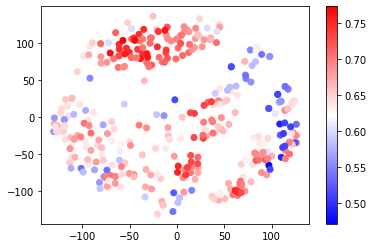

In [11]:
# Load the embedding results
with open((output_path / 'embeddings.pckl'), 'rb') as handle:
    embeddings = pickle.load(handle)
# Load the labels for the analysis
with open(output_path / 'abide_space.pckl', 'rb') as handle:
    Data_Run = pickle.load(handle)
# Load indices of the subjects used for train and test
with open((output_path / f'indices_space_train.json'), 'rb') as handle:
    indices = json.load(handle)

# TODO: make this more generalisable. We will use the MDS space
model_embedding = embeddings['MDS']

abide_df = load_abide_demographics(data_root)
# Remove subjects that were used to create the space
train_df = abide_df.iloc[indices['idx_train']]
train_labels = train_df['DX_GROUP']
files_id = train_df['FILE_ID']

PredictedAcc = np.zeros((len(Data_Run['Results'])))
for count in tqdm(range(len(Data_Run['Results']))):
    PredictedAcc[count] = objective_func_class(Data_Run['methods_idx'], count, train_labels, files_id,
                                                   data_raw, output_path)

# Dump predictions
pickle.dump(PredictedAcc, open(str(output_path / 'predictedAcc.pckl'), 'wb'))

plt.figure()
plt.scatter(model_embedding[0: PredictedAcc.shape[0], 0],
            model_embedding[0: PredictedAcc.shape[0], 1],
            c=(PredictedAcc)*10, cmap='bwr')
plt.colorbar()
plt.savefig(output_path / 'Predictions.png')

# 5. Active Learning

Note: This step also requires the user to previously downalod the raw data. Due to computation limitations with colab, we are only providing the active learning without repetitions.

In [12]:
import pickle
import json
import numpy

from helperfunctions import (initialize_bo, run_bo, load_abide_demographics, plot_bo_estimated_space, plot_bo_evolution,
                             posteriorOnlyModels, plot_bo_repetions)

In [22]:
def compute_active_learning(kappa, model_config, CassOrRegression):
    # Load data demographics
    abide_df = load_abide_demographics(data_root)

    # Load the embedding results
    with open((output_path / 'embeddings.pckl'), 'rb') as handle:
        embeddings = pickle.load(handle)
    with open(output_path / 'abide_space.pckl', 'rb') as handle:
        Data_Run = pickle.load(handle)
    with open((output_path / 'predictedAcc.pckl'), 'rb') as handle:
        PredictedAcc = pickle.load(handle)
    model_embedding = embeddings['MDS']
    # Load indices of the subjects used for train and test
    with open((output_path / f'indices_space_train.json'), 'rb') as handle:
        indices = json.load(handle)
    # Remove subjects that were used to create the space
    train_df = abide_df.iloc[indices['idx_train']]
    Y = train_df['DX_GROUP']
    files_id = train_df['FILE_ID']

    # Check range of predictions
    PredictedAcc = pickle.load(open(str(output_path / "predictedAcc.pckl"), "rb"))
    print(f'Max {np.max(PredictedAcc)}')
    print(f'Min {np.min(PredictedAcc)}')
    print(f'Mean and std {np.mean(PredictedAcc) * 10} and {np.std(PredictedAcc) * 10}')

    model_config['Data_Run'] = Data_Run['methods_idx']
    model_config['files_id'] = train_df['FILE_ID']
    model_config['output_path'] = output_path

    kernel, optimizer, utility, init_points, n_iter, pbounds, nbrs, RandomSeed = \
        initialize_bo(model_embedding, kappa)

    BadIter = run_bo(optimizer, utility, init_points, n_iter,
           pbounds, nbrs, RandomSeed, model_embedding, model_config,
           Y, ClassOrRegression, MultivariateUnivariate=True,
           repetitions=False, verbose=True)

    x_exploratory, y_exploratory, z_exploratory, x, y, gp, vmax, vmin = \
        plot_bo_estimated_space(kappa, BadIter, optimizer, pbounds, model_embedding, PredictedAcc, kernel,
                                output_path, ClassOrRegression)

    corr = plot_bo_evolution(kappa, x_exploratory, y_exploratory, z_exploratory, x, y, gp,
                             vmax, vmin, model_embedding, PredictedAcc, output_path, ClassOrRegression)

    print(f'Spearman correlation {corr}')

In [16]:
kappa = 10.0
# path to the raw data
model_config = {}
model_config['data_root'] = data_raw
ClassOrRegression = 'Classification'
compute_active_learning(kappa, model_config, ClassOrRegression)


  0%|                                                                         | 0/60 [00:00<?, ?it/s]

Max 0.07736635075450865
Min 0.04713884799411115
Mean and std 0.6549169186048555 and 0.060863812940407595
Next point to probe is: {'b1': 112.26614467041827, 'b2': 23.9296120163701}


  0%|                                                                       | 0/60 [6:52:40<?, ?it/s]

  2%|█                                                                | 1/60 [00:58<57:59, 58.98s/it]

Next Iteration
0
Print indices: 383  379
3.3322257180717103
Target Function: 0.0560
 
Next point to probe is: {'b1': 87.86839291163702, 'b2': 2.2903684027413647}



  3%|██▏                                                              | 2/60 [01:35<44:14, 45.76s/it]

Next Iteration
1
Print indices: 255  251
13.203077765627366
Target Function: 0.0519
 
Next point to probe is: {'b1': 44.149527545236225, 'b2': 6.3164785056941355}



  5%|███▎                                                             | 3/60 [02:28<46:42, 49.17s/it]

Next Iteration
2
Print indices: 339  161
7.5624898393700875
Target Function: 0.0688
 
Next point to probe is: {'b1': -101.66512715729037, 'b2': -74.10974646050846}



  7%|████▎                                                            | 4/60 [03:16<45:12, 48.44s/it]

Next Iteration
3
Print indices: 226  202
2.6685127672191773
Target Function: 0.0583
 
Next point to probe is: {'b1': -89.91476725847042, 'b2': 56.6844621732094}



  8%|█████▍                                                           | 5/60 [03:50<39:56, 43.58s/it]

Next Iteration
4
Print indices: 51  53
4.641008913998001
Target Function: 0.0551
 
Next point to probe is: {'b1': 48.91380899458383, 'b2': -54.05004385286526}



 10%|██████▌                                                          | 6/60 [05:25<54:44, 60.82s/it]

Next Iteration
5
Print indices: 217  219
21.288501150954147
Target Function: 0.0651
 
Next point to probe is: {'b1': -103.0202544189641, 'b2': 68.19821300100233}



 12%|███████▌                                                         | 7/60 [06:15<50:40, 57.36s/it]

Next Iteration
6
Print indices: 53  220
7.527614050078114
Target Function: 0.0651
 
Next point to probe is: {'b1': 0.08548501433909905, 'b2': -114.89274279971498}



 13%|████████▋                                                        | 8/60 [07:21<52:05, 60.11s/it]

Next Iteration
7
Print indices: 371  307
1.0441005880682546
Target Function: 0.0584
 
Next point to probe is: {'b1': -103.25000123132182, 'b2': -96.09945294695817}



 15%|█████████▊                                                       | 9/60 [07:56<44:18, 52.12s/it]

Next Iteration
8
Print indices: 206  226
21.998899745476056
Target Function: 0.0586
 
Next point to probe is: {'b1': 4.487863142804343, 'b2': -119.56827720692444}



 17%|██████████▋                                                     | 10/60 [08:50<43:54, 52.69s/it]

Next Iteration
9
Print indices: 371  307
5.607681915990024
Target Function: 0.0584
 
Next point to probe is: {'b1': 45.148164525273614, 'b2': -0.9811848885370296}



 18%|███████████▋                                                    | 11/60 [09:48<44:31, 54.53s/it]

Next Iteration
10
Print indices: 339  343
1.8702270923099547
Target Function: 0.0688
 
Next point to probe is: {'b1': 48.572212912444456, 'b2': -1.10818427325043}
Next Iteration
11
10.611170920994475
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 42.840568347417076, 'b2': 2.9602388436062483}



 20%|████████████▊                                                   | 12/60 [10:45<44:15, 55.32s/it]

Next Iteration
12
Print indices: 339  343
5.5307029628086894
Target Function: 0.0688
 
Next point to probe is: {'b1': 41.368222310620496, 'b2': -3.534042632398908}



 22%|█████████████▍                                                | 13/60 [13:07<1:03:42, 81.34s/it]

Next Iteration
13
Print indices: 275  343
4.516035884996159
Target Function: 0.0703
 
Next point to probe is: {'b1': 41.58982856991648, 'b2': 1.869599845717289}



 23%|██████████████▉                                                 | 14/60 [13:59<55:34, 72.48s/it]

Next Iteration
14
Print indices: 339  343
5.981134058437637
Target Function: 0.0688
 
Next point to probe is: {'b1': 43.23297302200797, 'b2': -0.0683091390520758}



 25%|████████████████                                                | 15/60 [14:56<50:55, 67.89s/it]

Next Iteration
15
Print indices: 339  343
7.372010616985776
Target Function: 0.0699
 
Next point to probe is: {'b1': 43.96847835227666, 'b2': 0.1660342156817478}



 27%|█████████████████                                               | 16/60 [15:42<44:53, 61.22s/it]

Next Iteration
16
Print indices: 339  343
3.145830690172504
Target Function: 0.0688
 
Next point to probe is: {'b1': 42.54038197324501, 'b2': -0.4447608182674615}



 28%|██████████████████▏                                             | 17/60 [16:29<40:59, 57.21s/it]

Next Iteration
17
Print indices: 339  343
6.5837225548407385
Target Function: 0.0699
 
Next point to probe is: {'b1': 41.741426957454706, 'b2': 0.9075789448618252}



 30%|███████████████████▏                                            | 18/60 [17:14<37:23, 53.41s/it]

Next Iteration
18
Print indices: 339  343
5.491683142265399
Target Function: 0.0688
 
Next point to probe is: {'b1': 43.445526203812875, 'b2': -0.17525827524301008}



 32%|████████████████████▎                                           | 19/60 [17:58<34:28, 50.44s/it]

Next Iteration
19
Print indices: 339  343
7.510138529144297
Target Function: 0.0699
 
Next point to probe is: {'b1': 41.8337771852386, 'b2': -0.30116886511362395}



 33%|█████████████████████▎                                          | 20/60 [18:40<32:04, 48.10s/it]

Next Iteration
20
Print indices: 339  343
5.17643901431636
Target Function: 0.0688
 
Next point to probe is: {'b1': 27.20321399927232, 'b2': 2.9194910469788624}



 35%|██████████████████████▍                                         | 21/60 [20:39<44:59, 69.22s/it]

Next Iteration
21
Print indices: 289  279
9.013122071996301
Target Function: 0.0737
 
Next point to probe is: {'b1': 17.474162579680467, 'b2': 10.68532926707286}



 37%|███████████████████████▍                                        | 22/60 [22:48<55:20, 87.38s/it]

Next Iteration
22
Print indices: 289  293
5.765163631204375
Target Function: 0.0732
 
Next point to probe is: {'b1': 42.087186583283255, 'b2': 0.25784312892378125}



 38%|████████████████████████▌                                       | 23/60 [23:40<47:11, 76.52s/it]

Next Iteration
23
Print indices: 339  343
4.999088511242797
Target Function: 0.0688
 
Next point to probe is: {'b1': 18.91231685922321, 'b2': 9.815776831770279}



 40%|████████████████████████▍                                    | 24/60 [26:15<1:00:07, 100.20s/it]

Next Iteration
24
Print indices: 289  293
4.674141856428674
Target Function: 0.0737
 
Next point to probe is: {'b1': 17.720102685569287, 'b2': 11.51084085082391}



 42%|█████████████████████████▍                                   | 25/60 [28:20<1:02:51, 107.77s/it]

Next Iteration
25
Print indices: 289  293
6.591112980782721
Target Function: 0.0732
 
Next point to probe is: {'b1': 11.598495881615037, 'b2': -2.3109376018728085}



 43%|███████████████████████████▋                                    | 26/60 [28:43<46:33, 82.16s/it]

Next Iteration
26
Print indices: 135  293
6.473008109512984
Target Function: 0.0657
 
Next point to probe is: {'b1': 22.50985580573507, 'b2': 1.8058026432551912}



 45%|████████████████████████████▊                                   | 27/60 [30:31<49:29, 89.98s/it]

Next Iteration
27
Print indices: 289  293
5.249505305215891
Target Function: 0.0737
 
Next point to probe is: {'b1': 9.965889533635254, 'b2': 11.97902068764685}



 47%|█████████████████████████████▊                                  | 28/60 [32:32<52:51, 99.12s/it]

Next Iteration
28
Print indices: 293  289
7.40866738546361
Target Function: 0.0732
 
Next point to probe is: {'b1': 9.649654132261276, 'b2': 11.859753526803217}
Next Iteration
29
11.077822420996737
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 12.633813886589934, 'b2': 1.0617941557984807}



 48%|██████████████████████████████▍                                | 29/60 [34:22<53:00, 102.60s/it]

Next Iteration
30
Print indices: 293  135
5.113515616574646
Target Function: 0.0732
 
Next point to probe is: {'b1': 23.84517780704428, 'b2': 3.1197644807155314}



 50%|███████████████████████████████▌                               | 30/60 [36:15<52:47, 105.59s/it]

Next Iteration
31
Print indices: 289  293
5.7468052580610225
Target Function: 0.0737
 
Next point to probe is: {'b1': 22.895818707323315, 'b2': 4.515076245905277}



 52%|████████████████████████████████▌                              | 31/60 [38:06<51:47, 107.16s/it]

Next Iteration
32
Print indices: 289  293
8.779633533127399
Target Function: 0.0732
 
Next point to probe is: {'b1': 25.58295717280788, 'b2': 4.212203152237038}



 53%|█████████████████████████████████▌                             | 32/60 [39:55<50:20, 107.89s/it]

Next Iteration
33
Print indices: 289  279
7.172566422296847
Target Function: 0.0737
 
Next point to probe is: {'b1': 23.67330389531736, 'b2': 2.7004589748543992}



 55%|██████████████████████████████████▋                            | 33/60 [41:49<49:17, 109.55s/it]

Next Iteration
34
Print indices: 289  293
9.977690230687255
Target Function: 0.0732
 
Next point to probe is: {'b1': 21.888613048033903, 'b2': 3.455442152259593}



 57%|███████████████████████████████████▋                           | 34/60 [43:38<47:29, 109.58s/it]

Next Iteration
35
Print indices: 289  293
3.8178050427899772
Target Function: 0.0737
 
Next point to probe is: {'b1': 24.260513338781436, 'b2': 2.6409420790334366}
Next Iteration
36
10.26549977362126
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 18.81830008981015, 'b2': 5.159048509477373}



 58%|████████████████████████████████████▊                          | 35/60 [45:28<45:42, 109.70s/it]

Next Iteration
37
Print indices: 289  293
0.3447237191838359
Target Function: 0.0737
 
Next point to probe is: {'b1': 17.5856409367629, 'b2': 5.800674078519222}



 60%|█████████████████████████████████████▊                         | 36/60 [47:34<45:47, 114.46s/it]

Next Iteration
38
Print indices: 289  293
3.358435969788433
Target Function: 0.0732
 
Next point to probe is: {'b1': -126.04431919267437, 'b2': 75.02698978574591}
Next Iteration
39
24.948622745873703
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 18.461737894440205, 'b2': 6.449601171624494}



 62%|██████████████████████████████████████▊                        | 37/60 [49:38<44:59, 117.39s/it]

Next Iteration
40
Print indices: 289  293
1.2873853409069203
Target Function: 0.0737
 
Next point to probe is: {'b1': 18.855644813808283, 'b2': 4.2192939322874565}



 63%|███████████████████████████████████████▉                       | 38/60 [51:49<44:32, 121.47s/it]

Next Iteration
41
Print indices: 289  293
4.929026349238156
Target Function: 0.0732
 
Next point to probe is: {'b1': 18.01032646056089, 'b2': 5.6458948780230855}



 65%|████████████████████████████████████████▉                      | 39/60 [53:46<42:05, 120.25s/it]

Next Iteration
42
Print indices: 289  293
0.6697066992398284
Target Function: 0.0737
 
Next point to probe is: {'b1': 18.075685275289402, 'b2': 4.0302498608476185}



 67%|██████████████████████████████████████████                     | 40/60 [56:00<41:24, 124.24s/it]

Next Iteration
43
Print indices: 289  293
4.285524242420902
Target Function: 0.0732
 
Next point to probe is: {'b1': 59.981509749506216, 'b2': 135.79520130748057}
Next Iteration
44
18.66927432565628
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 17.186168119149556, 'b2': 6.18264584298899}



 68%|███████████████████████████████████████████                    | 41/60 [58:19<40:43, 128.59s/it]

Next Iteration
45
Print indices: 289  293
1.6427491636069513
Target Function: 0.0737
 
Next point to probe is: {'b1': 17.100016592378978, 'b2': 6.180590513970628}



 70%|██████████████████████████████████████████▋                  | 42/60 [1:01:03<41:46, 139.25s/it]

Next Iteration
46
Print indices: 289  293
2.8824917397350123
Target Function: 0.0732
 
Next point to probe is: {'b1': 17.86346555003439, 'b2': 4.2321331471249835}



 72%|███████████████████████████████████████████▋                 | 43/60 [1:03:21<39:23, 139.06s/it]

Next Iteration
47
Print indices: 289  293
1.112388825712534
Target Function: 0.0737
 
Next point to probe is: {'b1': 123.28654628082052, 'b2': -129.29406110251028}
Next Iteration
48
59.01406018892269
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 17.627474913729998, 'b2': 5.815221592873627}



 73%|████████████████████████████████████████████▋                | 44/60 [1:06:13<39:39, 148.70s/it]

Next Iteration
49
Print indices: 289  293
1.068764900218133
Target Function: 0.0737
 
Next point to probe is: {'b1': 18.43816027716713, 'b2': 5.899460288364992}



 75%|█████████████████████████████████████████████▊               | 45/60 [1:08:36<36:47, 147.16s/it]

Next Iteration
50
Print indices: 289  293
4.2088842328287175
Target Function: 0.0732
 
Next point to probe is: {'b1': 18.747529925048354, 'b2': 6.471111132336034}



 77%|██████████████████████████████████████████████▊              | 46/60 [1:10:51<33:29, 143.57s/it]

Next Iteration
51
Print indices: 289  293
1.3372009412252763
Target Function: 0.0737
 
Next point to probe is: {'b1': -39.27626181426926, 'b2': 133.9450450987261}
Next Iteration
52
14.14694337403223
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 18.75688481443609, 'b2': 5.479365201647511}



 78%|███████████████████████████████████████████████▊             | 47/60 [1:13:02<30:14, 139.55s/it]

Next Iteration
53
Print indices: 289  293
0.4252108358942587
Target Function: 0.0737
 
Next point to probe is: {'b1': 19.13982090925188, 'b2': 5.60408922159624}



 80%|████████████████████████████████████████████████▊            | 48/60 [1:15:19<27:46, 138.84s/it]

Next Iteration
54
Print indices: 289  293
4.9206474562691245
Target Function: 0.0732
 
Next point to probe is: {'b1': 126.09423005178456, 'b2': 101.04031755093595}
Next Iteration
55
34.03370367835741
Target Function Default Bad: 0.0519
 
Next point to probe is: {'b1': 13.013942018236264, 'b2': 4.414906698397289}



 82%|█████████████████████████████████████████████████▊           | 49/60 [1:17:31<25:06, 136.96s/it]

Next Iteration
56
Print indices: 293  289
1.9345625654096068
Target Function: 0.0732
 
Next point to probe is: {'b1': 17.652590092700564, 'b2': 6.294876387590023}



 83%|███████████████████████████████████████████████████▋          | 50/60 [1:19:40<15:56, 95.62s/it]

Next Iteration
57
Print indices: 289  293
1.3988707979977058
Target Function: 0.0737
 


Spearman correlation SpearmanrResult(correlation=0.3668878646578563, pvalue=1.1139955102210775e-13)


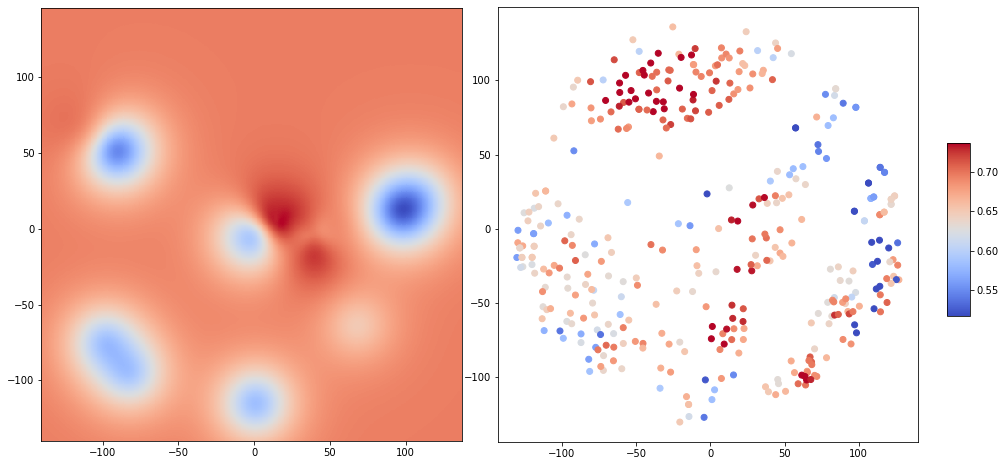

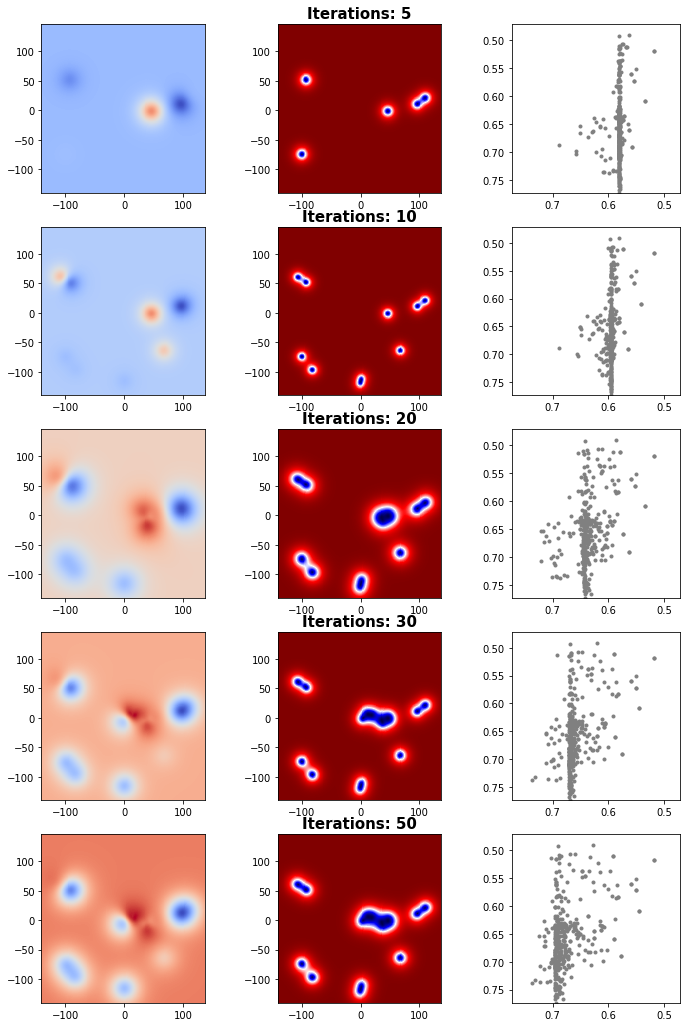

In [24]:
kappa = .1
# path to the raw data
model_config = {}
model_config['data_root'] = data_raw
ClassOrRegression = 'Classification'
compute_active_learning(kappa, model_config, ClassOrRegression)